In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from numpy import float64
import pandas as pd
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
import os
import pathlib
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

In [ ]:
!pip install lyon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyspikes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lyon.calc import LyonCalc
from librosa import load
import librosa
from spikes import encoder
import pathlib
import os
from IPython.display import Audio, display

In [ ]:
def calc_sig(waveform,sample_rate,decimation_factor=64):
  calc=LyonCalc()
  coch=calc.lyon_passive_ear(waveform.astype(float64),sample_rate,decimation_factor)
  samples=np.reshape(coch,[1,coch.shape[0],coch.shape[1]])
  bsa=encoder.BSA(samples)
  spks_normal=bsa.get_spikes()
  spks_normal=np.reshape(spks_normal,(spks_normal.shape[1],spks_normal.shape[2]))
  return coch,spks_normal

In [ ]:
#reference: https://stackoverflow.com/questions/71915018/mix-second-audio-clip-at-specific-snr-to-original-audio-file-in-python
def mix_audio(signal, noise, snr=20):
    # if the audio is longer than the noise
    # play the noise in repeat for the duration of the audio
    noise = noise[np.arange(len(signal)) % len(noise)]
    
    # if the audio is shorter than the noi
    # this is important if loading resulted in 
    # uint8 or uint16 types, because it would cause overflow
    # when squaring and calculating mean
    noise = noise.astype(np.float32)
    signal = signal.astype(np.float32)
    
    # get the initial energy for reference
    signal_energy = np.mean(signal**2)
    noise_energy = np.mean(noise**2)
    # calculates the gain to be applied to the noise 
    # to achieve the given SNR
    g = np.sqrt(10.0 ** (-snr/10) * signal_energy / noise_energy)
    
    # Assumes signal and noise to be decorrelated
    # and calculate (a, b) such that energy of 
    # a*signal + b*noise matches the energy of the input signal
    a = np.sqrt(1 / (1 + g**2))
    b = np.sqrt(g**2 / (1 + g**2))
    #print(g, a, b)
    # mix the signals
    return a * signal + b * noise


In [ ]:
#v_vbd: batch_size,n_vb
n_vb=10
in_size=96
N=in_size
in_e=4.0
in_vbd=7.0
e_l0=7.0
vbd_l0=2.0
in_l0=3.0

in_E=in_e*np.ones((in_size,1))
in_VBD=in_vbd*np.ones((n_vb,1))
E_L0=e_l0*np.ones((1,N))
VBD_L0=vbd_l0*np.ones((1,N))
in_L0=np.diag(in_l0*np.ones((96,)))

dt = 1.0
tauK = 4.0
C = 10
Vk = 0

dg = 1
aK = dt/C

In [ ]:
def run_gate(Sin,V_vbd,V_e,V_l0,in_E,in_VBD,in_L0,E_L0,VBD_L0,num_iter,batch_size,N,n_vb,aK,dg=1,tau_u=10.0,th_vb=5.0,th_e=12.0,th_l=1.0,dt=1.0,ref_p=1,tauK=2.0,Vk=0):
  Svbd=[]
  Se=[]
  Sl0=[]
  S_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  S_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  S_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  u_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  u_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  u_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  gk = tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  for i in range(num_iter):
    gk=(1-dt/tauK)*gk+dg*dt*S_e #memory of total spikes in neuron so far
    u_e=(1/tau_u)*tf.matmul(Sin[:,i,:],in_E)
    V_e=(dt*u_e)*(1-aK*gk)
    S_e=tf.cast(V_e>=th_e,dtype=tf.float32)
    u_vbd=(1/tau_u)*tf.matmul(Sin[:,i,:n_vb],in_VBD)
    V_vbd=dt*u_vbd
    S_vbd=tf.cast(V_vbd>=th_vb,dtype=tf.float32)
    u_l0=(1/tau_u)*(tf.matmul(Sin[:,i,:],in_L0)+tf.matmul(S_e,E_L0)+tf.matmul(S_vbd,VBD_L0))
    #V_l0=(1-aK*gk)*V_l0+dt*u_l0 #?sfa in L0 neurons
    V_l0=dt*u_l0
    S_l0=tf.cast(V_l0>=th_l,dtype=tf.float32)
    Se.append(S_e)
    Svbd.append(S_vbd)
    Sl0.append(S_l0)
  return tf.stack(Se,axis=1),tf.stack(Svbd,axis=1),tf.stack(Sl0,axis=1)

In [ ]:
words={'en': 'enter',
 'er': 'erase',
 'go': 'go',
 'hp': 'help',
 'no': 'no',
 'rb': 'rubout',
 'rp': 'repeat',
 'sp': 'stop',
 'st': 'start',
 'ys': 'yes'}

In [ ]:
wv,sr=load("/content/drive/MyDrive/sem7/BTP/ti_alpha/train/f1/hpf1set3.sph")
l=len(wv)

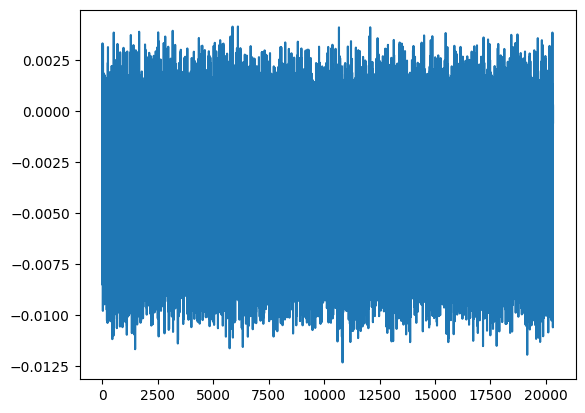

In [ ]:
noisePath='/content/drive/MyDrive/sem8/BTP II/noiseFiles'
file_noise='tcs_indoor_home_noise.wav'
start_idx=1153976
w,sr=load(os.path.join(noisePath,file_noise))
noise=w[start_idx:start_idx+l] #noise segment that is roughly uniform and predictable
display(Audio(noise,rate=sr))
plt.plot(noise)

In [ ]:
import re

tr_path='/content/drive/MyDrive/sem7/BTP/ti_alpha/train'
ts_path='/content/drive/MyDrive/sem7/BTP/ti_alpha/test'

data_clean=[]
data_noisy=[]
labels=[]

for sp in os.listdir(tr_path):
  tr_1=os.path.join(tr_path,sp)
  ts_1=os.path.join(ts_path,sp)
  for fl in os.listdir(tr_1):
    if re.search("^[a-z]",fl) is not None:
      labels.append(words[fl[:2]])
      wv,sr=load(os.path.join(tr_1,fl))
      _,s=calc_sig(wv,sr)
      data_clean.append(s)
      nsp=mix_audio(wv,noise)
      _,s=calc_sig(nsp,sr)
      data_noisy.append(s)
  for fl in os.listdir(ts_1):
    if re.search("^[a-z]",fl) is not None:
      labels.append(words[fl[:2]])
      wv,sr=load(os.path.join(ts_1,fl))
      _,s=calc_sig(wv,sr)
      data_clean.append(s)
      nsp=mix_audio(wv,noise)
      _,s=calc_sig(nsp,sr)
      data_noisy.append(s)

In [ ]:
S_clean=pd.Series(data_clean)
S_noisy=pd.Series(data_noisy)
shapes=S_clean.apply(lambda x:x.shape[0])
if(min(shapes)!=max(shapes)):
  S_clean=S_clean.apply(lambda x:np.concatenate((x,np.zeros((max(shapes)-x.shape[0],x.shape[1])))).astype(np.uint64))
  S_noisy=S_noisy.apply(lambda x:np.concatenate((x,np.zeros((max(shapes)-x.shape[0],x.shape[1])))).astype(np.uint64))

In [ ]:
train_split=0.8
S_tr_noisy=S_noisy[:round(len(S_noisy)*train_split)]
S_ts_noisy=S_noisy[round(len(S_noisy)*train_split):]

In [ ]:
S_tr_clean=S_clean[:round(len(S_noisy)*train_split)]

In [ ]:
#gating
batch_size=20

S_l_f=[]
for bn in range(len(S_tr_noisy)//batch_size):
  x_d=[]
  _=S_tr_noisy[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  V_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  _,_,S_l0=run_gate(batch_in_full_tf,V_vbd,V_e,V_l0,in_E,in_VBD,in_L0,E_L0,VBD_L0,num_iter,batch_size,N,n_vb,aK)
  S_l_f.append(S_l0)

Sl0_train=tf.concat(S_l_f,0)

S_l_f=[]
for bn in range(len(S_ts_noisy)//batch_size):
  x_d=[]
  _=S_ts_noisy[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  V_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  _,_,S_l0=run_gate(batch_in_full_tf,V_vbd,V_e,V_l0,in_E,in_VBD,in_L0,E_L0,VBD_L0,num_iter,batch_size,N,n_vb,aK)
  S_l_f.append(S_l0)

Sl0_test=tf.concat(S_l_f,0)

S_train=[]
S_test=[]
for i in range(Sl0_train.numpy().shape[0]):
  S_train.append(Sl0_train[i].numpy().flatten())
for i in range(Sl0_test.numpy().shape[0]):
  S_test.append(Sl0_test[i].numpy().flatten())

In [ ]:
train_labels=labels[:round(len(S_noisy)*train_split)]
test_labels=labels[round(len(S_noisy)*train_split):]

In [ ]:
Sc_train=[]
_=S_tr_clean.apply(lambda x:Sc_train.append(x.flatten()))

In [ ]:
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(S_train, train_labels[:len(S_train)])
print(clf.score(S_test,test_labels[:len(S_test)]))

0.8804878048780488


In [ ]:
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(Sc_train, train_labels[:len(Sc_train)])
print(clf.score(S_test,test_labels[:len(S_test)]))

0.7012195121951219


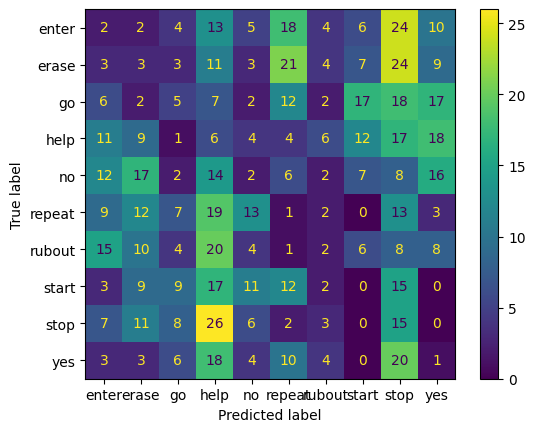

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

test_predict = clf.predict(S_test)
cm = confusion_matrix(labels[:len(S_test)], test_predict, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
Sn_train=[]
Sn_test=[]
_=S_tr_noisy.apply(lambda x:Sn_train.append(x.flatten()))
_=S_ts_noisy.apply(lambda x:Sn_test.append(x.flatten()))

In [ ]:
#training and testing on noisy data
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(Sn_train, train_labels[:len(Sn_train)])
print(clf.score(Sn_test,test_labels[:len(Sn_test)]))

0.9239130434782609


In [ ]:
#training on clean, testing on noisy
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(Sc_train, train_labels[:len(Sc_train)])
print(clf.score(Sn_test,test_labels[:len(Sn_test)]))

0.5736714975845411


##Adding an LSM

In [ ]:
Nx = 10
Ny = 10
Nz = 10
Nl = Nx*Ny*Nz

#NMNIST no STDP params: inW = 3, LqW = 1.5
#New NMNIST no STDP params, derived from MNIST scaling: inW = 27, LqW = 2
#NMNIST in_conn_density = 0.15

#Golden standard settings: inW = 5*16, LqW = 0.1*16, Nx=Ny=Nz=12

#wt_mult_fac is approximately the ratio: input spikes per time-step(NMNIST) / input spikes per time-step(TI-46)
wt_mult_fac = 10
in_conn_div_factor = 1

#inW is scaled in such a way that the net input to the Liquid is conserved
inW = 27*wt_mult_fac*in_conn_div_factor
inh_fac = 1
in_conn_density = 0.15/in_conn_div_factor

LqW = 2
inh_fr = 0.2
lam = 9

W_lsm = np.zeros((Nl,Nl))
W_in = np.zeros((in_size,Nl))
W_lsm_mask = np.ones((Nl,Nl))

in_conn_range = np.int32(Nl*in_conn_density)
for i in range(in_size):
  input_perm_i = np.arange(Nl)
  np.random.shuffle(input_perm_i)
  pos_conn = input_perm_i[:in_conn_range]
  neg_conn = input_perm_i[-in_conn_range:]
  W_in[i,pos_conn] = inW
  W_in[i,neg_conn] = -1*inh_fac*inW

input_perm = np.arange(Nl)
np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
inh_range = np.int32(inh_fr*Nl) # indices 0 to inh_range-1 are inhibitory

for i in range(Nl):
  posti = input_perm[i] # input_perm[i] is the post-neuron index
  zi = posti//(Nx*Ny)
  yi = (posti-zi*Nx*Ny)//Nx
  xi = (posti-zi*Nx*Ny)%Nx
  for j in range(Nl):
    prej = input_perm[j] # input_perm[j] is the pre-neuron index
    zj = prej//(Nx*Ny)
    yj = (prej-zj*Nx*Ny)//Nx
    xj = (prej-zj*Nx*Ny)%Nx
    D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
    if i<inh_range and j<inh_range: # II connection, C = 0.3
      P = 0.3*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i<inh_range and j>=inh_range: # EI connection, C = 0.1
      P = 0.1*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW
    if i>=inh_range and j<inh_range: # IE connection, C = 0.05
      P = 0.05*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
      P = 0.2*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW

for i in range(Nl):
  W_lsm[i,i] = 0
  W_lsm_mask[i,i] = 0

abs_W_lsm = np.abs(W_lsm)

print("average fan out: ", np.mean(np.sum(abs_W_lsm>0, axis=1)))

average fan out:  14.119


In [ ]:
def run_gateLSM(Sin,Vm,V_vbd,V_e,V_l0,in_E,in_VBD,in_L0,E_L0,VBD_L0,in_W,W_lsm,num_iter,batch_size,N,Nl,n_vb,aK,g=1/1.6,th=20,dg=1,tau_u=10.0,th_vb=5.0,th_e=12.0,th_l=1.0,dt=1.0,ref_p=1,tauK=2.0,Vk=0):
  Svbd=[]
  Se=[]
  Sl0=[]
  S_liq=[]
  S_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  S_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  S_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  u_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  u_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  u_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  gk = tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  SI=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  u=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  ref_counter=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  for i in range(num_iter):
    gk=(1-dt/tauK)*gk+dg*dt*S_e #memory of total spikes in neuron so far
    u_e=(1/tau_u)*tf.matmul(Sin[:,i,:],in_E)
    V_e=(dt*u_e)*(1-aK*gk)
    S_e=tf.cast(V_e>=th_e,dtype=tf.float32)
    u_vbd=(1/tau_u)*tf.matmul(Sin[:,i,:n_vb],in_VBD)
    V_vbd=dt*u_vbd
    S_vbd=tf.cast(V_vbd>=th_vb,dtype=tf.float32)
    u_l0=(1/tau_u)*(tf.matmul(Sin[:,i,:],in_L0)+tf.matmul(S_e,E_L0)+tf.matmul(S_vbd,VBD_L0))
    #V_l0=(1-aK*gk)*V_l0+dt*u_l0 #?sfa in L0 neurons
    V_l0=dt*u_l0
    S_l0=tf.cast(V_l0>=th_l,dtype=tf.float32)
    Se.append(S_e)
    Svbd.append(S_vbd)
    Sl0.append(S_l0)
    u=np.exp(-1/tau_u)*u+(1/tau_u)*(tf.matmul(S_l0,in_W)+tf.matmul(SI,W_lsm))
    Vm=((1-g*aK)*Vm+dt*u)*(tf.cast(ref_counter==0,dtype=tf.float32))
    ref_counter=ref_counter+tf.cast(Vm>=th,dtype=tf.float32)*ref_p-tf.cast(ref_counter>0,dtype=tf.float32)
    SI=tf.cast(Vm>=th,dtype=tf.float32)
    Vm=tf.cast(Vm<th,dtype=tf.float32)*Vm
    S_liq.append(SI)
  return tf.stack(S_liq,axis=1)

In [ ]:
def run_LSM(Vm,Sin,in_W,W_lsm,num_iter,batch_size,Nl,aK,tau_u=10.0,g=1/1.6,dt=1.0,th=20,ref_p=1):
  S_liq=[]
  SI=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  u=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  ref_counter=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  for i in range(num_iter):
    u=np.exp(-1/tau_u)*u+(1/tau_u)*(tf.matmul(Sin[:,i,:],in_W)+tf.matmul(SI,W_lsm))
    Vm=((1-g*aK)*Vm+dt*u)*(tf.cast(ref_counter==0,dtype=tf.float32))
    ref_counter=ref_counter+tf.cast(Vm>=th,dtype=tf.float32)*ref_p-tf.cast(ref_counter>0,dtype=tf.float32)
    SI=tf.cast(Vm>=th,dtype=tf.float32)
    Vm=tf.cast(Vm<th,dtype=tf.float32)*Vm
    S_liq.append(SI)
  return tf.stack(S_liq,axis=1)

In [ ]:
#gating
batch_size=200

LSM_out_train = np.zeros((len(S_tr_noisy),Nl*4))

for bn in range(len(S_tr_noisy)//batch_size):
  x_d=[]
  _=S_tr_clean[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  partition = num_iter//4 #4partitions
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  Vm=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  S_liq=run_LSM(Vm,batch_in_full_tf,W_in,W_lsm,num_iter,batch_size,Nl,aK)
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  LSM_out_train[bn*batch_size:(bn+1)*batch_size] = S_liq_c.numpy()


LSM_out_test = np.zeros((len(S_ts_noisy),Nl*4))

for bn in range(len(S_ts_noisy)//batch_size):
  x_d=[]
  _=S_ts_noisy[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  V_vbd=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_e=tf.convert_to_tensor(np.zeros((batch_size,1)),dtype=tf.float32)
  V_l0=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  Vm=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  S_liq=run_gateLSM(batch_in_full_tf,Vm,V_vbd,V_e,V_l0,in_E,in_VBD,in_L0,E_L0,VBD_L0,W_in,W_lsm,num_iter,batch_size,N,Nl,n_vb,aK)
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  LSM_out_test[bn*batch_size:(bn+1)*batch_size] = S_liq_c.numpy()

training linear model on LSM
train score = 0.9692214846107423
test score = 0.6038647342995169


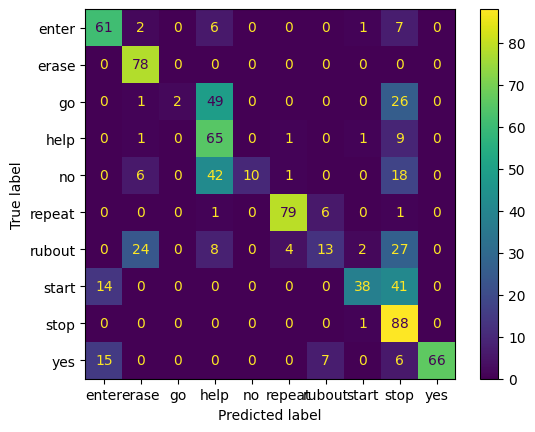

In [ ]:
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay

print("training linear model on LSM")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(LSM_out_train, train_labels[:len(LSM_out_train)])

train_score = clf.score(LSM_out_train, train_labels[:len(LSM_out_train)])
print("train score = " + str(train_score))

score = clf.score(LSM_out_test, test_labels[:len(LSM_out_test)])
print("test score = " + str(score))

test_predict = clf.predict(LSM_out_test)
cm = confusion_matrix(test_labels[:len(LSM_out_test)], test_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
#gating
batch_size=200

LSM_out_train = np.zeros((len(S_tr_noisy),Nl*4))

for bn in range(len(S_tr_noisy)//batch_size):
  x_d=[]
  _=S_tr_clean[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  partition = num_iter//4 #4partitions
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  Vm=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  S_liq=run_LSM(Vm,batch_in_full_tf,W_in,W_lsm,num_iter,batch_size,Nl,aK)
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  LSM_out_train[bn*batch_size:(bn+1)*batch_size] = S_liq_c.numpy()


LSM_out_test = np.zeros((len(S_ts_noisy),Nl*4))

for bn in range(len(S_ts_noisy)//batch_size):
  x_d=[]
  _=S_ts_noisy[bn*batch_size:(bn+1)*batch_size].apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  batch_in_full_tf=tf.constant(x_d,dtype=tf.float32)
  Vm=tf.convert_to_tensor(np.zeros((batch_size,Nl)),dtype=tf.float32)
  S_liq=run_LSM(Vm,batch_in_full_tf,W_in,W_lsm,num_iter,batch_size,Nl,aK)
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  LSM_out_test[bn*batch_size:(bn+1)*batch_size] = S_liq_c.numpy()

training linear model on LSM
train score = 0.9695232347616174
test score = 0.4251207729468599


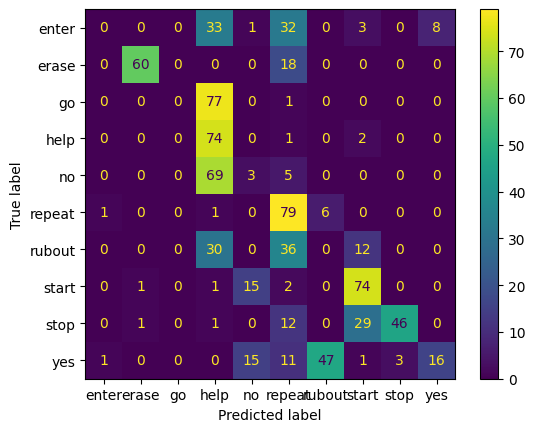

In [ ]:
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay

print("training linear model on LSM")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(LSM_out_train, train_labels[:len(LSM_out_train)])

train_score = clf.score(LSM_out_train, train_labels[:len(LSM_out_train)])
print("train score = " + str(train_score))

score = clf.score(LSM_out_test, test_labels[:len(LSM_out_test)])
print("test score = " + str(score))

test_predict = clf.predict(LSM_out_test)
cm = confusion_matrix(test_labels[:len(LSM_out_test)], test_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()